In [128]:
#import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np


# font
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.size"] = 15
plt.rcParams["legend.fontsize"] = 15

# ticks
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["xtick.top"] = True
plt.rcParams["xtick.labeltop"] = False
plt.rcParams["ytick.right"] = True
plt.rcParams["ytick.labelright"] = False
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

# figure
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams['figure.subplot.left'] = 0.15

In [129]:
# Planck constant (m^2 kg / s)
h = 6.62607015e-34
"""Plank constant."""

# speed of light (m / s)
c = 2.99792458e8
"""Speed of light."""

# elementary charge (C)
e = 1.60217663e-19
"""Elementary charge."""

# composite constants
hc = h * c
"""Product of Plank constant and speed of light."""

magnetic_flux_quantum = h / e
"""Magnetic flux quantum."""

klitzing_constant = h / e**2
"""Klitzing constant."""

'Klitzing constant.'

In [130]:
def true_circle_in(Y: np.ndarray, X: np.ndarray, y0: float, x0: float, radius: float) -> np.ndarray:
    return (X - x0)**2 + (Y - y0)**2 <= radius**2


def calc_confinement_potential_at(
    bulk_index: np.ndarray,
    boundary_indices: np.ndarray,
    dl: float = 1,
) -> float:
    potential_density = (
        (bulk_index[0] - boundary_indices[:, 0] + 1e-20)**2 +
        (bulk_index[1] - boundary_indices[:, 1] + 1e-20)**2
    )**(-3 / 2) * dl
    return np.sum(potential_density)


def apply_confinement_potential(
    energy: np.ndarray,
    bulk_indices: np.ndarray,
    boundary_indices: np.ndarray,
    alpha: float,
    dl: float = 1,
) -> np.ndarray:
    for bulk_index in bulk_indices:
        energy[bulk_index[0], bulk_index[1]] += calc_confinement_potential_at(
            bulk_index,
            boundary_indices,
            dl=dl,
        ) * alpha / 2
    return energy


def apply_local_constant_potential(
    energy: np.ndarray,
    val: float,
    space_indices: np.ndarray,
) -> np.ndarray:
    for x_gate, y_gate in space_indices:
        energy[x_gate, y_gate] += val
    return energy


def apply_QH_energy(
    energy: np.ndarray,
    QH_energy: np.ndarray,
    bulk_indices: np.ndarray,
) -> np.ndarray:
    for x_bulk, y_bulk in bulk_indices:
        energy[x_bulk, y_bulk] += QH_energy
    return energy


def find_edge(energy: np.ndarray, E_F: float, U_fluc: float, bulk: np.ndarray) -> np.ndarray:
    edge = np.zeros_like(energy)
    upper = E_F - U_fluc <= energy
    lower = energy <= E_F + U_fluc
    edge[np.where(upper & lower)] = 1

    # TODO
    for index_x in range(len(edge)):
        if np.sum(edge[index_x, :]) != 0:
            continue

        for index_y, is_lower in enumerate(lower[index_x, :]):
            if is_lower and (bulk[index_x, index_y] == 1):
                edge[index_x, index_y] = 1
                break

    return edge

**Simulation Parameters**

In [131]:
hbar = h / (2 * np.pi)
n = 1e15        # m^-2
B_0 = n * magnetic_flux_quantum / 1
dielectric_vacuum = 8.8854e-12      # F/m
dielectric_GaAs = 12.9 * dielectric_vacuum
m_e = 9.109e-31     # kg
m_GaAs = 0.067 * m_e
k_B = 1.380649e-23
T = 40e-3

M = 20  # multiplier of magnetic length
l_B = np.sqrt(h / (2 * np.pi * e * B_0))
l = l_B * M

E_0 = e**2 / (4 * np.pi * dielectric_GaAs * l)
E_LL_diff = hbar * e * B_0 / (m_GaAs * E_0)
E_F = E_LL_diff / 2
E_QH = E_F / 2

E_gate_min = 0
E_gate_max = E_F

U_etching9 = 0.3
U_etching8 = U_etching9 + 0.3
U_etching7 = U_etching8 + 0.3
U_etching6 = U_etching7 + 0.3
U_etching5 = U_etching6 + 0.3
U_etching4 = U_etching5 + 0.3
U_etching3 = U_etching4 + 0.3
U_etching2 = U_etching3 + 0.3
U_etching1 = U_etching2 + 0.3

U_thermal = k_B * T / E_0
U_disorder = (60e-6 * e) / E_0
U_fluc = U_disorder + U_thermal

In [132]:
print(f"E_F = {E_F}")
print(f"U_fluc = {U_fluc}")
print(f"2 um / l = {2e-6 / l}")

E_F = 8.104990760116417
U_fluc = 0.14391857894307894
2 um / l = 7.926654595212022


**Definition of Space**

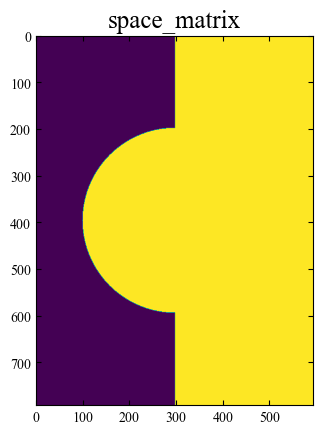

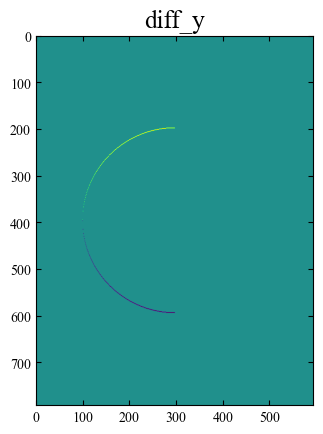

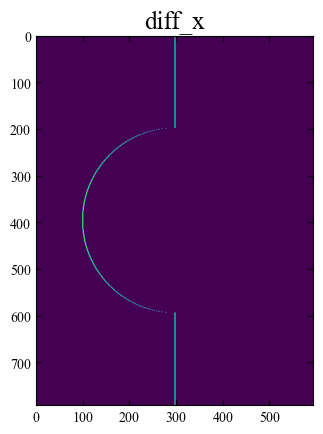

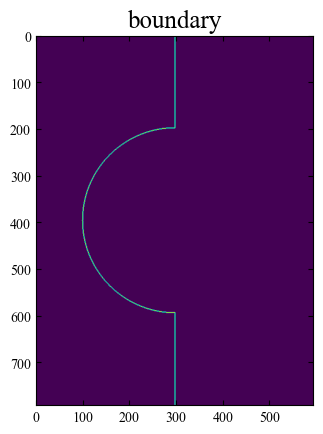

[  0 298]


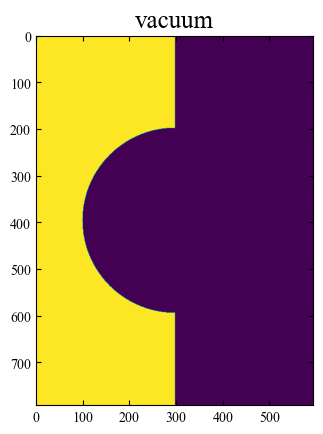

In [133]:
import matplotlib.pyplot as plt
radius_gate = int(50e-6 / l)

x = np.arange(0, int(200e-6 / l), 1)
y = np.arange(0, int(150e-6 / l), 1)
Y, X = np.meshgrid(y, x)

space_matrix = (
    true_circle_in(Y, X, y[len(y) // 2], x[len(x) // 2], radius_gate) |
    (Y >= y[len(y) // 2])
).astype(int)
plt.imshow(space_matrix)
plt.title("space_matrix")
plt.show()
diff_y = np.gradient(space_matrix, 1, axis=0)
plt.imshow(diff_y)
plt.title("diff_y")
plt.show()
diff_x = np.gradient(space_matrix, 1, axis=1)
plt.imshow(diff_x)
plt.title("diff_x")
plt.show()

# sample edge
boundary = ((diff_x != 0) | (diff_y != 0)).astype(int)
boundary_y = y[np.where(boundary == 1)[1]]
boundary_x = x[np.where(boundary == 1)[0]]
boundary_indices = np.array(np.where(boundary == 1)).T
plt.imshow(boundary)
plt.title("boundary")
plt.show()

# bulk (space \ sample edge)
bulk = np.copy(space_matrix)
bulk[boundary == 1] = 0
bulk_indices = np.array(np.where(bulk == 1)).T
print(bulk_indices[0])

# vacuum
vacuum = np.copy((~space_matrix.astype(bool)).astype(int))
plt.imshow(vacuum)
plt.title("vacuum")
plt.show()

In [134]:
# shallow etching region 1
etched1 = np.logical_xor(
    true_circle_in(Y, X, y[len(y) // 2], x[len(x) // 2], radius_gate),
    true_circle_in(Y, X, y[len(y) // 2], x[len(x) // 2], radius_gate - int(5e-6 / l)),
).astype(int)
etched1[Y >= y[len(y) // 2]] = 0
etched1[boundary == 1] = 0
etched1_indices = np.array(np.where(etched1 == 1)).T

# shallow etching region 2
etched2 = np.logical_xor(
    true_circle_in(Y, X, y[len(y) // 2], x[len(x) // 2], radius_gate - int(5e-6 / l)),
    true_circle_in(Y, X, y[len(y) // 2], x[len(x) // 2], radius_gate - int(9e-6 / l)),
).astype(int)
etched2[Y >= y[len(y) // 2]] = 0
etched2[boundary == 1] = 0
etched2[etched1 == 1] = 0
etched2_indices = np.array(np.where(etched2 == 1)).T

# shallow etching region 3
etched3 = np.logical_xor(
    true_circle_in(Y, X, y[len(y) // 2], x[len(x) // 2], radius_gate - int(9e-6 / l)),
    true_circle_in(Y, X, y[len(y) // 2], x[len(x) // 2], radius_gate - int(11e-6 / l)),
).astype(int)
etched3[Y >= y[len(y) // 2]] = 0
etched3[boundary == 1] = 0
etched3[etched1 == 1] = 0
etched3[etched2 == 1] = 0
etched3_indices = np.array(np.where(etched3 == 1)).T

# shallow etching region 4
etched4 = np.logical_xor(
    true_circle_in(Y, X, y[len(y) // 2], x[len(x) // 2], radius_gate - int(11e-6 / l)),
    true_circle_in(Y, X, y[len(y) // 2], x[len(x) // 2], radius_gate - int(13e-6 / l)),
).astype(int)
etched4[Y >= y[len(y) // 2]] = 0
etched4[boundary == 1] = 0
etched4[etched1 == 1] = 0
etched4[etched2 == 1] = 0
etched4[etched3 == 1] = 0
etched4_indices = np.array(np.where(etched4 == 1)).T

# shallow etching region 5
etched5 = np.logical_xor(
    true_circle_in(Y, X, y[len(y) // 2], x[len(x) // 2], radius_gate - int(13e-6 / l)),
    true_circle_in(Y, X, y[len(y) // 2], x[len(x) // 2], radius_gate - int(15e-6 / l)),
).astype(int)
etched5[Y >= y[len(y) // 2]] = 0
etched5[boundary == 1] = 0
etched5[etched1 == 1] = 0
etched5[etched2 == 1] = 0
etched5[etched3 == 1] = 0
etched5[etched4 == 1] = 0
etched5_indices = np.array(np.where(etched5 == 1)).T

# shallow etching region 6
etched6 = np.logical_xor(
    true_circle_in(Y, X, y[len(y) // 2], x[len(x) // 2], radius_gate - int(15e-6 / l)),
    true_circle_in(Y, X, y[len(y) // 2], x[len(x) // 2], radius_gate - int(17e-6 / l)),
).astype(int)
etched6[Y >= y[len(y) // 2]] = 0
etched6[boundary == 1] = 0
etched6[etched1 == 1] = 0
etched6[etched2 == 1] = 0
etched6[etched3 == 1] = 0
etched6[etched4 == 1] = 0
etched6[etched5 == 1] = 0
etched6_indices = np.array(np.where(etched6 == 1)).T

# shallow etching region 7
etched7 = np.logical_xor(
    true_circle_in(Y, X, y[len(y) // 2], x[len(x) // 2], radius_gate - int(17e-6 / l)),
    true_circle_in(Y, X, y[len(y) // 2], x[len(x) // 2], radius_gate - int(19e-6 / l)),
).astype(int)
etched7[Y >= y[len(y) // 2]] = 0
etched7[boundary == 1] = 0
etched7[etched1 == 1] = 0
etched7[etched2 == 1] = 0
etched7[etched3 == 1] = 0
etched7[etched4 == 1] = 0
etched7[etched5 == 1] = 0
etched7[etched6 == 1] = 0
etched7_indices = np.array(np.where(etched7 == 1)).T

# shallow etching region 8
etched8 = np.logical_xor(
    true_circle_in(Y, X, y[len(y) // 2], x[len(x) // 2], radius_gate - int(19e-6 / l)),
    true_circle_in(Y, X, y[len(y) // 2], x[len(x) // 2], radius_gate - int(21e-6 / l)),
).astype(int)
etched8[Y >= y[len(y) // 2]] = 0
etched8[boundary == 1] = 0
etched8[etched1 == 1] = 0
etched8[etched2 == 1] = 0
etched8[etched3 == 1] = 0
etched8[etched4 == 1] = 0
etched8[etched5 == 1] = 0
etched8[etched6 == 1] = 0
etched8[etched7 == 1] = 0
etched8_indices = np.array(np.where(etched8 == 1)).T

# shallow etching region 9
etched9 = np.logical_xor(
    true_circle_in(Y, X, y[len(y) // 2], x[len(x) // 2], radius_gate - int(21e-6 / l)),
    true_circle_in(Y, X, y[len(y) // 2], x[len(x) // 2], radius_gate - int(23e-6 / l)),
).astype(int)
etched9[Y >= y[len(y) // 2]] = 0
etched9[boundary == 1] = 0
etched9[etched1 == 1] = 0
etched9[etched2 == 1] = 0
etched9[etched3 == 1] = 0
etched9[etched4 == 1] = 0
etched9[etched5 == 1] = 0
etched9[etched6 == 1] = 0
etched9[etched7 == 1] = 0
etched9[etched8 == 1] = 0
etched9_indices = np.array(np.where(etched9 == 1)).T

# expansion gate
gate = np.logical_xor(
    true_circle_in(Y, X, y[len(y) // 2], x[len(x) // 2], radius_gate),
    true_circle_in(Y, X, y[len(y) // 2], x[len(x) // 2], radius_gate - int(25e-6 / l)),
).astype(int)
gate[Y >= y[len(y) // 2]] = 0
gate[boundary == 1] = 0
gate_indices = np.array(np.where(gate == 1)).T

**Adjusting the parameter of the confinement potential $\alpha$**

In [135]:
energy = np.zeros_like(space_matrix, dtype=float)
energy = apply_confinement_potential(energy, bulk_indices, boundary_indices, 1)

KeyboardInterrupt: 

In [ ]:
print(np.max(energy))

2.2769578957317074


In [ ]:
alpha = 1e3

# PoC interpretation

**Execution check without applying local potential**

In [ ]:
energy = np.zeros_like(space_matrix, dtype=float)
energy = apply_QH_energy(energy, E_QH, bulk_indices)
energy = apply_confinement_potential(energy, bulk_indices, boundary_indices, alpha)

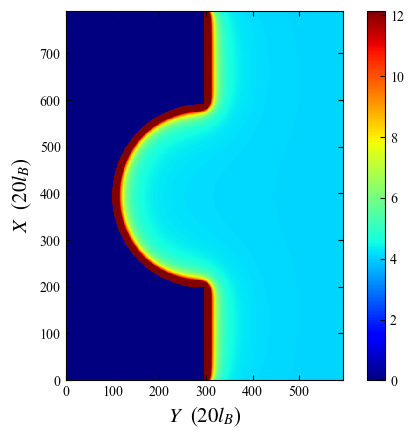

In [ ]:
fig, axis = plt.subplots()

cplot = axis.pcolor(
    y,
    x,
    energy,
    cmap="jet",
    shading="nearest",
)
cplot.set_clim(0, E_F * 3 / 2)

axis.set_aspect("equal")
axis.set_xlabel("$Y$  ($" + f"{M:d}" + " l_B$)")
axis.set_ylabel("$X$  ($" + f"{M:d}" + " l_B$)")

fig.colorbar(cplot)

plt.show()

<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\p'
C:\Users\jaymi\AppData\Local\Temp\ipykernel_39916\402658528.py:9: SyntaxWarning: invalid escape sequence '\m'
  axis.axhline(E_F, color="black", linestyle="dashed", label="$E_\mathrm{F}$")
C:\Users\jaymi\AppData\Local\Temp\ipykernel_39916\402658528.py:12: SyntaxWarning: invalid escape sequence '\m'
  axis.text(120, 2.5, "10 $\mathrm{\mu m}$")
C:\Users\jaymi\AppData\Local\Temp\ipykernel_39916\402658528.py:18: SyntaxWarning: invalid escape sequence '\p'
  axis.set_ylabel("Energy  ($e^2 / 4 \pi \epsilon l_0$)")


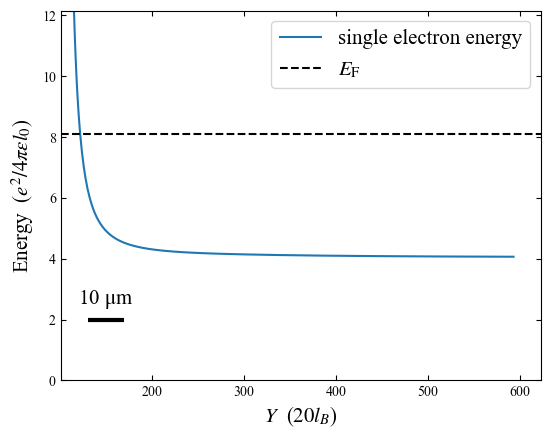

In [ ]:
fig, axis = plt.subplots()

axis.plot(
    y,
    energy[len(x) // 2, :],
    label="single electron energy",
)

axis.axhline(E_F, color="black", linestyle="dashed", label="$E_\mathrm{F}$")

axis.hlines(2, 130, 130 + 10e-6 / l, color="black", linewidth=3)
axis.text(120, 2.5, "10 $\mathrm{\mu m}$")

axis.set_xlim(101)
axis.set_ylim(0, E_F * 3 / 2)

axis.set_xlabel("$Y$  ($" + f"{M:d}" + " l_B$)")
axis.set_ylabel("Energy  ($e^2 / 4 \pi \epsilon l_0$)")

axis.legend()
plt.show()

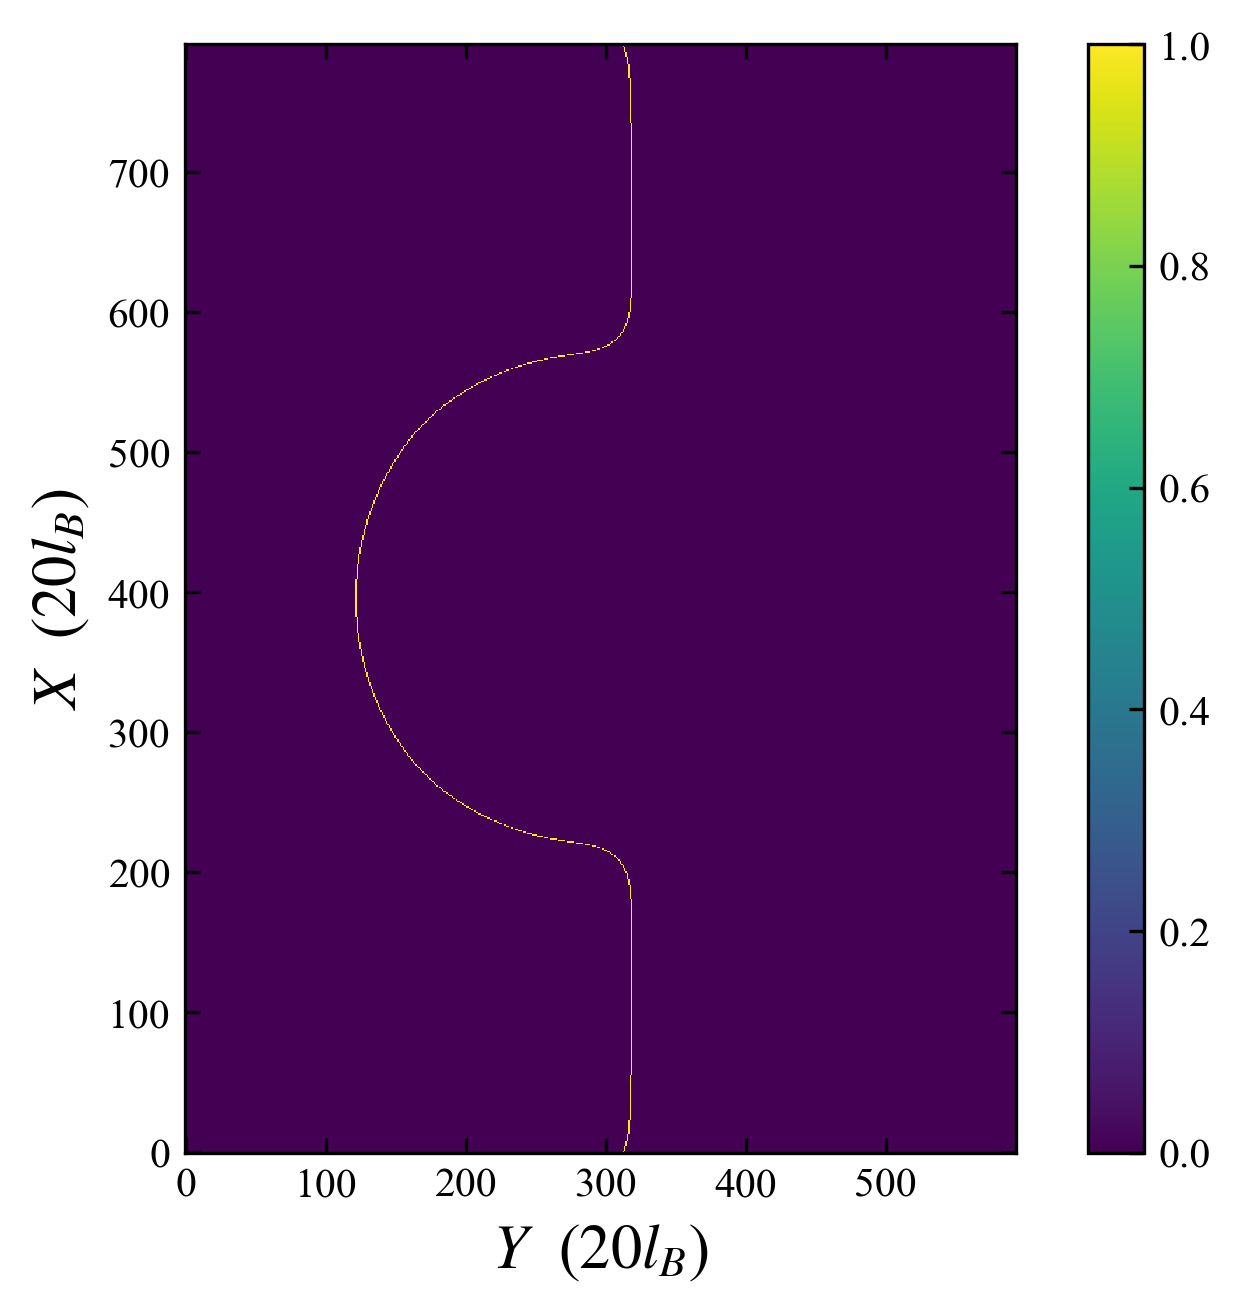

In [ ]:
fig, axis = plt.subplots()

cplot = axis.pcolor(
    y,
    x,
    find_edge(energy, E_F, U_fluc, bulk),
    shading="nearest",
)

axis.set_aspect("equal")
axis.set_xlabel("$Y$  ($" + f"{M:d}" + " l_B$)")
axis.set_ylabel("$X$  ($" + f"{M:d}" + " l_B$)")

fig.colorbar(cplot)

fig.dpi = 300
plt.show()

**Introducing etching potentials**

In [ ]:
energy = apply_local_constant_potential(energy, U_etching1, etched1_indices)
energy = apply_local_constant_potential(energy, U_etching2, etched2_indices)
energy = apply_local_constant_potential(energy, U_etching3, etched3_indices)
energy = apply_local_constant_potential(energy, U_etching4, etched4_indices)
energy = apply_local_constant_potential(energy, U_etching5, etched5_indices)
energy = apply_local_constant_potential(energy, U_etching6, etched6_indices)
energy = apply_local_constant_potential(energy, U_etching7, etched7_indices)
energy = apply_local_constant_potential(energy, U_etching8, etched8_indices)
energy = apply_local_constant_potential(energy, U_etching9, etched9_indices)

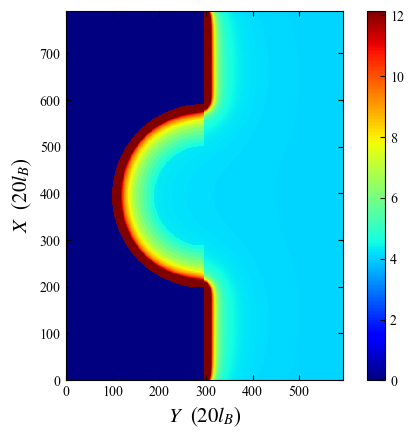

In [ ]:
fig, axis = plt.subplots()

cplot = axis.pcolor(
    y,
    x,
    energy,
    cmap="jet",
    shading="nearest",
)
cplot.set_clim(0, E_F * 3 / 2)

axis.set_aspect("equal")
axis.set_xlabel("$Y$  ($" + f"{M:d}" + " l_B$)")
axis.set_ylabel("$X$  ($" + f"{M:d}" + " l_B$)")

fig.colorbar(cplot)

plt.show()

<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\p'
C:\Users\jaymi\AppData\Local\Temp\ipykernel_39916\402658528.py:9: SyntaxWarning: invalid escape sequence '\m'
  axis.axhline(E_F, color="black", linestyle="dashed", label="$E_\mathrm{F}$")
C:\Users\jaymi\AppData\Local\Temp\ipykernel_39916\402658528.py:12: SyntaxWarning: invalid escape sequence '\m'
  axis.text(120, 2.5, "10 $\mathrm{\mu m}$")
C:\Users\jaymi\AppData\Local\Temp\ipykernel_39916\402658528.py:18: SyntaxWarning: invalid escape sequence '\p'
  axis.set_ylabel("Energy  ($e^2 / 4 \pi \epsilon l_0$)")


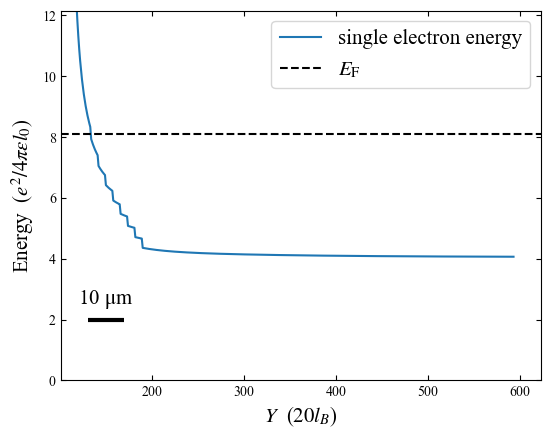

In [ ]:
fig, axis = plt.subplots()

axis.plot(
    y,
    energy[len(x) // 2, :],
    label="single electron energy",
)

axis.axhline(E_F, color="black", linestyle="dashed", label="$E_\mathrm{F}$")

axis.hlines(2, 130, 130 + 10e-6 / l, color="black", linewidth=3)
axis.text(120, 2.5, "10 $\mathrm{\mu m}$")

axis.set_xlim(101)
axis.set_ylim(0, E_F * 3 / 2)

axis.set_xlabel("$Y$  ($" + f"{M:d}" + " l_B$)")
axis.set_ylabel("Energy  ($e^2 / 4 \pi \epsilon l_0$)")

axis.legend()
plt.show()

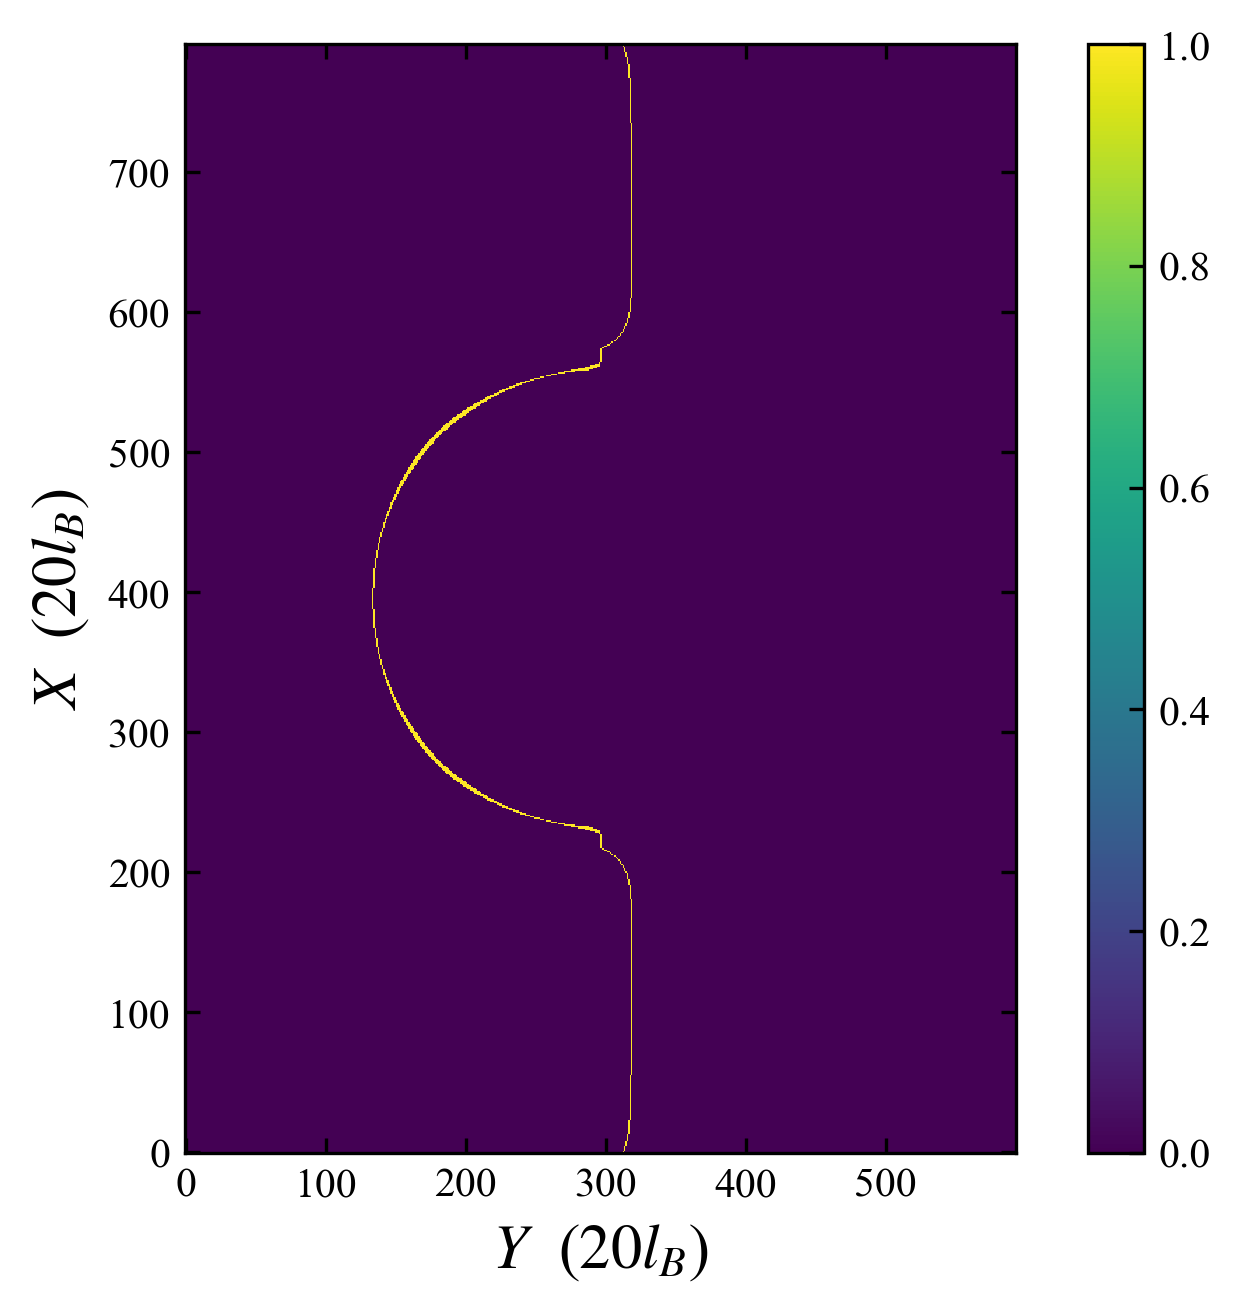

In [ ]:
fig, axis = plt.subplots()

cplot = axis.pcolor(
    y,
    x,
    find_edge(energy, E_F, U_fluc, bulk),
    shading="nearest",
)

axis.set_aspect("equal")
axis.set_xlabel("$Y$  ($" + f"{M:d}" + " l_B$)")
axis.set_ylabel("$X$  ($" + f"{M:d}" + " l_B$)")

fig.colorbar(cplot)

fig.dpi = 300
plt.show()

**Main simulation**

In [ ]:
energy = np.zeros_like(space_matrix, dtype=float)
energy = apply_QH_energy(energy, E_QH, bulk_indices)
energy = apply_confinement_potential(energy, bulk_indices, boundary_indices, alpha)

energy = apply_local_constant_potential(energy, U_etching1, etched1_indices)
energy = apply_local_constant_potential(energy, U_etching2, etched2_indices)
energy = apply_local_constant_potential(energy, U_etching3, etched3_indices)
energy = apply_local_constant_potential(energy, U_etching4, etched4_indices)
energy = apply_local_constant_potential(energy, U_etching5, etched5_indices)
energy = apply_local_constant_potential(energy, U_etching6, etched6_indices)
energy = apply_local_constant_potential(energy, U_etching7, etched7_indices)
energy = apply_local_constant_potential(energy, U_etching8, etched8_indices)
energy = apply_local_constant_potential(energy, U_etching9, etched9_indices)

<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\p'
C:\Users\jaymi\AppData\Local\Temp\ipykernel_39916\2497101357.py:22: SyntaxWarning: invalid escape sequence '\m'
  axes[1].axhline(E_F, color="black", linestyle="dashed", label="$E_\mathrm{F}$")
C:\Users\jaymi\AppData\Local\Temp\ipykernel_39916\2497101357.py:25: SyntaxWarning: invalid escape sequence '\m'
  axes[1].text(120, 2.5, "10 $\mathrm{\mu m}$")
C:\Users\jaymi\AppData\Local\Temp\ipykernel_39916\2497101357.py:29: SyntaxWarning: invalid escape sequence '\p'
  axes[1].set_ylabel("Energy  ($e^2 / 4 \pi \epsilon l_0$)")
C:\Users\jaymi\AppData\Local\Temp\ipykernel_39916\2497101357.py:22: SyntaxWarning: invalid escape sequence '\m'
  axes[1].axhline(E_F, color="black", linestyle="dashed

KeyboardInterrupt: 

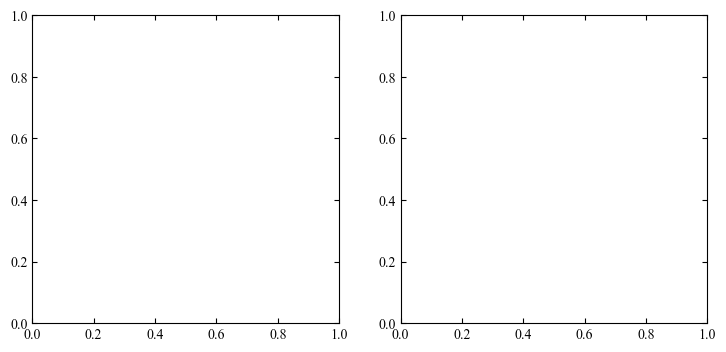

In [ ]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(9, 4)

# edge 2D plot
cplot = axes[0].pcolor(
    y,
    x,
    find_edge(energy, E_F, U_fluc, bulk),
    shading="nearest",
)
axes[0].set_aspect("equal")
axes[0].set_xlabel("$Y$  ($" + f"{M:d}" + " l_B$)")
axes[0].set_ylabel("$X$  ($" + f"{M:d}" + " l_B$)")
fig.colorbar(cplot)

# energy 1D plot
axes[1].plot(
    y,
    energy[len(x) // 2, :],
    label="single electron energy",
)
axes[1].axhline(E_F, color="black", linestyle="dashed", label="$E_\mathrm{F}$")
axes[1].axhspan(E_F - U_fluc, E_F + U_fluc, color="red", alpha=0.3)
axes[1].hlines(1.5, 130, 130 + 10e-6 / l, color="black", linewidth=3)
axes[1].text(120, 2.5, "10 $\mathrm{\mu m}$")
axes[1].set_xlim(101)
axes[1].set_ylim(0, E_F * 2.5)
axes[1].set_xlabel("$Y$  ($" + f"{M:d}" + " l_B$)")
axes[1].set_ylabel("Energy  ($e^2 / 4 \pi \epsilon l_0$)")
axes[1].legend(fontsize=12)

fig.dpi = 300
plt.show()

<>:43: SyntaxWarning: invalid escape sequence '\m'
<>:46: SyntaxWarning: invalid escape sequence '\m'
<>:50: SyntaxWarning: invalid escape sequence '\p'
<>:43: SyntaxWarning: invalid escape sequence '\m'
<>:46: SyntaxWarning: invalid escape sequence '\m'
<>:50: SyntaxWarning: invalid escape sequence '\p'
C:\Users\jaymi\AppData\Local\Temp\ipykernel_39916\1637591760.py:43: SyntaxWarning: invalid escape sequence '\m'
  axes[1].axhline(E_F, color="black", linestyle="dashed", label="$E_\mathrm{F}$")
C:\Users\jaymi\AppData\Local\Temp\ipykernel_39916\1637591760.py:46: SyntaxWarning: invalid escape sequence '\m'
  axes[1].text(120, 2.5, "10 $\mathrm{\mu m}$")
C:\Users\jaymi\AppData\Local\Temp\ipykernel_39916\1637591760.py:50: SyntaxWarning: invalid escape sequence '\p'
  axes[1].set_ylabel("Energy  ($e^2 / 4 \pi \epsilon l_0$)")
MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4

Error in callback <function _draw_all_if_interactive at 0x000002234D272CA0> (for post_execute), with arguments args (),kwargs {}:


KeyError: <Axes: label='<colorbar>'>

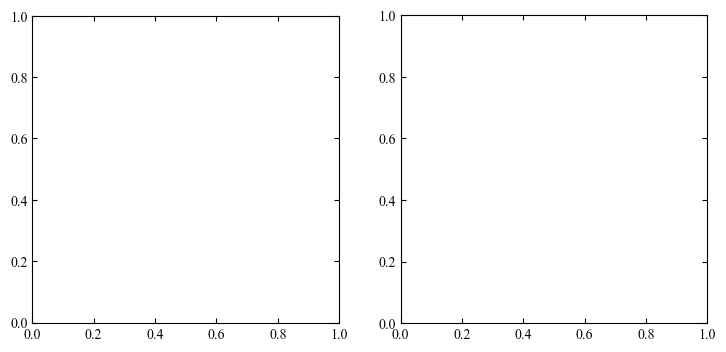

In [ ]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(9, 4)
cbar = None
frames = 101
E_gate_step = (E_gate_max - E_gate_min) / (frames - 1)
edge_length = []

def plot_anim(index: int) -> None:
    global cbar
    global energy

    if cbar is not None:
        cbar.remove()
    axes[0].cla()
    axes[1].cla()

    if index > 0:
        energy = apply_local_constant_potential(energy, E_gate_step, gate_indices)

    edge = find_edge(energy, E_F, U_fluc, bulk)
    if len(edge_length) == index:
        edge_length.append(len(np.where(find_edge(energy, E_F, U_fluc, bulk)[len(x) // 2, :] == 1)[0]))

    # edge 2D plot
    cplot = axes[0].pcolor(
        y,
        x,
        edge,
        shading="nearest",
    )
    axes[0].set_aspect("equal")
    axes[0].set_xlabel("$Y$  ($" + f"{M:d}" + " l_B$)")
    axes[0].set_ylabel("$X$  ($" + f"{M:d}" + " l_B$)")
    axes[0].set_title(f"step: {index}")
    cbar = fig.colorbar(cplot, orientation="vertical")

    # energy 1D plot
    axes[1].plot(
        y,
        energy[len(x) // 2, :],
        label="single electron energy",
    )
    axes[1].axhline(E_F, color="black", linestyle="dashed", label="$E_\mathrm{F}$")
    axes[1].axhspan(E_F - U_fluc, E_F + U_fluc, color="red", alpha=0.3)
    axes[1].hlines(1.5, 130, 130 + 10e-6 / l, color="black", linewidth=3)
    axes[1].text(120, 2.5, "10 $\mathrm{\mu m}$")
    axes[1].set_xlim(101)
    axes[1].set_ylim(0, E_F * 2.5)
    axes[1].set_xlabel("$Y$  ($" + f"{M:d}" + " l_B$)")
    axes[1].set_ylabel("Energy  ($e^2 / 4 \pi \epsilon l_0$)")
    axes[1].legend(fontsize=12)

anim = animation.FuncAnimation(fig, plot_anim, interval=100, frames=frames)
anim.save("PoC.mp4", dpi=300)

In [ ]:
edge_length = np.array(edge_length)
gate_potential = np.arange(0, frames) * E_gate_step

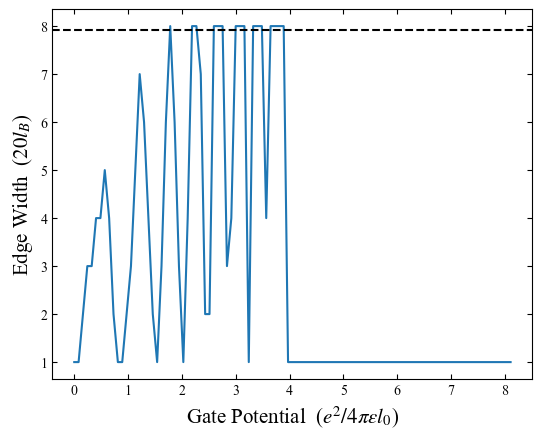

In [ ]:
fig, axis = plt.subplots()

axis.plot(
    gate_potential,
    edge_length,
)

axis.axhline(2e-6 / l, color="black", linestyle="dashed")

axis.set_xlabel("Gate Potential  ($e^2 / 4 \pi \epsilon l_0$)")
axis.set_ylabel("Edge Width  ($" + f"{M:d}" + " l_B$)")

plt.show()